# An analysis of the dataset presented in [this technical comment](https://arxiv.org/abs/2004.06601), but with our quality cuts applied

As a response to our paper [Dessert et al. _Science_ 2020](https://science.sciencemag.org/content/367/6485/1465) (DRS20), we received [a technical comment](https://arxiv.org/abs/2004.06601) (BRMS). BRMS performed a simplified version of our analysis in a partially overlapping dataset using 17 Ms of MOS observations spanning 20$^\circ$ to 35$^\circ$ from the Galactic Center. They assumed a single power-law background with additional lines at 3.1, 3.3, 3.7, and 3.9 keV, and claim a 4$\sigma$ detection of a line at 3.48 keV using an energy window of 3-4 keV. However, it is important to note that the BRMS analysis do not apply any (stated) quality cuts to their dataset. On the other hand, as detailed in DRS20, we selected low-background or blank-sky observations, so the data is much cleaner.

In our formal response to the technical comment, we repeat this analysis on the 8.5 Ms of the BRMS dataset that passes the quality cuts. In this notebook, we show this data and analysis in detail. Many of the details will follow the procedure used in the notebook `DRS20_mos_stacked`. For a pedagogical introduction to the analysis here, we refer to that notebook.

If you use the data in this example in a publication, please cite Dessert et al. _Science_ 2020.

**Please direct any questions to bsafdi@umich.edu.**

In [1]:
# Import required modules

%matplotlib inline
%load_ext autoreload
%autoreload 2
 
import sys,os
import numpy as np

from scipy.stats import chi2 as chi2_scipy
from scipy.optimize import dual_annealing
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rcParams['text.usetex'] = True
rcParams['text.latex.unicode'] = True

**NB**: In this notebook, we minimize with `scipy` so that it is easy to run for the interested reader. For scientific analysis, we recommend [Minuit](https://iminuit.readthedocs.io/en/latest/) as a minimizer. In our paper, we used Minuit.

# Define signal line energy

By default we will look for an anomalous line at 3.48 keV, as defined by the EUXL parameter below, denoting the energy of the unidentified X-ray line. Lines at different energies can be searched for by changing this parameter accordingly (for example to 3.55 keV as in the previous notebook). We start with 3.48 keV as this is the fiducial line energy in BMRS. We note that 3.48 keV is the energy where the weakest limit is obtained, although on the clean data we will not find any evidence for a feature there.

In [2]:
EUXL = 3.48 # [keV]

**NB:** changing EUXL will of course vary the results below, and values in the surrounding discussion will not necessarily be reflective.

# Load in the data and models

First we will load in the data products that we will use in the analysis.  These include the stacked MOS data, associated energy bins, and uncertainties. 

We will use data from two regions of interest (ROI):
- **Signal Region (SR)**: 20-35 degrees from the Galactic Center, this was the fiducial ROI in BRMS (DRS20 instead used 5-45);
- **Background Region (BR)**: 60-90 degrees from the Galactic Center, a useful region for studying background as it contains less dark matter.

We also load the appropriately averaged D-factors for these two regions (ROIs) for our fiducial NFW profile, along with the respective exposure times.

In [3]:
## Signal Region (20-35 degrees)
data = np.load("../data/data_mos_boyarsky_ROI_our_cuts.npy") # [cts/s/keV]
data_yerrs = np.load("../data/data_yerrs_mos_boyarsky_ROI_our_cuts.npy") # [cts/s/keV]
QPB = np.load("../data/QPB_mos_boyarsky_ROI_our_cuts.npy") # [cts/s/keV]

# Exposure time
Exp = 8.49e6 # [s]

# D-factor averaged over the signal ROI
D_signal = 4.4e28 # [keV/cm^2]


## Background Region (60-90 degrees)

# Data and associated errors
data_bkg = np.load("../data/data_mos_bkg_ROI.npy") # [cts/s/keV]
data_yerrs_bkg = np.load("../data/data_yerrs_mos_bkg_ROI.npy") # [cts/s/keV]

# Exposure time
Exp_bkg = 67.64e6 # [s]

# D-factor averaged over the background ROI
D_bkg = 1.91e28 # [keV/cm^2]

## Energy binning appropriate for both the signal and background
Energies=np.load("../data/mos_energies.npy") # [keV]

## Load in the Models

Next we use the models that will be used in fitting the above data.

There are a sequence of models corresponding to physical line fluxes at the energies specified by `Es_line`.  That is, `mod_UXL` gives the detectors counts as a function of energy after forward modeling a physical line at EUXL keV with a flux of 1 cts/cm$^2$/s/sr.

In [4]:
# Load the forward-modeled lines and energies
mods = np.load("../data/mos_mods.npy")
Es_line = np.load("../data/mos_mods_line_energies.npy")

# Load the detector response
det_res = np.load("../data/mos_det_res.npy")

arg_UXL = np.argmin((Es_line-EUXL)**2)
mod_UXL = mods[arg_UXL]

print "The energy of our "+str(EUXL)+" keV line example will be: "+str(Es_line[arg_UXL])+" keV"

# How to go from flux to sin^2(2\theta)
def return_sin_theta_lim(E_line,flux,D_factor):
    """
    D_factor [keV/cm^2]
    flux [cts/cm^2/s/sr]
    E_line [keV] (dark matter mass is twice this value)
    returns: associated sin^2(2theta)
    """
    DMmass = 2.*E_line
    res = (4.*np.pi*DMmass/D_factor)/1.361e-22*(1/DMmass)**5*flux
    return res

The energy of our 3.48 keV line example will be: 3.4824707846410687 keV


# Visualize the data

Data in the signal region, where the dashed vertical line denotes the location of a putative signal line. Note in particular the flux is similar to that in Fig. 2 of DRS20, indicating that the included observations are low-background. 

/sw/lsa/centos7/python-anaconda2/2019.03/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


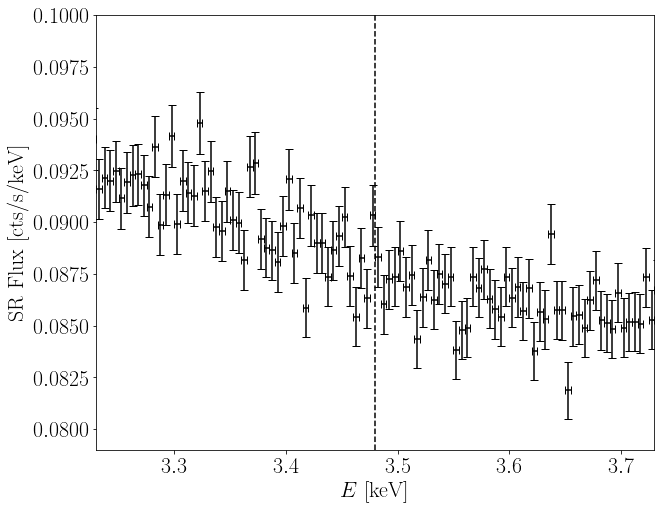

In [5]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(Energies,data,yerr=data_yerrs,xerr=(Energies[1]-Energies[0])/2.,
             color="black",label="data",marker="o", fmt='none',capsize=4)
plt.axvline(EUXL,color="black",linestyle="dashed")
plt.xlim(EUXL-0.25,EUXL+0.25)
plt.ylim(7.9e-2,0.1)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"SR Flux [cts/s/keV]",fontsize=22)
plt.show()

# Statistical analysis

Now, let's perform a rigorous statistical analysis, using profile likelihood. As we operate in the large counts limit for the stacked data, we can perform a simple $\chi^2$ analysis rather than a full joint likelihood analysis as used by default in Dessert et al. 2020.

In [6]:
## Define the functions we will use

class chi2:
    """ A set offunctions for calculation the chisq associated with different hypotheses
    """
    def __init__(self,ens,dat,err,null_mod,sig_template):
        self._ens = ens
        self._dat = dat
        self._err = err
        self._null_mod = null_mod
        self._sig_template = sig_template
        self._A_sig = 0.0
    
    def chi2(self,x):
        null_mod = self._null_mod(self._ens,x[1:])
        sig_mod = self._sig_template*x[0]
        return np.sum((self._dat - null_mod - sig_mod)**2/self._err**2)
    
    def chi2_null(self,x):
        null_mod = self._null_mod(self._ens,x)
        return np.sum((self._dat - null_mod)**2/self._err**2)
    
    def chi2_fixed_signal(self,x):
        null_mod = self._null_mod(self._ens,x)
        sig_mod = self._sig_template*self._A_sig
        return np.sum((self._dat - null_mod - sig_mod)**2/self._err**2) 
    
    def fix_signal_strength(self,A_sig):
        self._A_sig = A_sig

## Fit within $E_{\rm UXL} \pm 0.25$ keV

First, we will fit the models from $[E_{\rm UXL}-0.25,\,E_{\rm UXL}+0.25]$ keV. Later in this notebook, we broaden this range to 3.0 to 4.0 keV. For the default $E_{\rm UXL} = 3.48$ keV, this corresponds to $3.23~{\rm keV} < E < 3.73~{\rm keV}$.

To begin with then, let's reduce the dataset to this restricted range.

In [7]:
whs_reduced = np.where((Energies >= EUXL-0.25) & (Energies <= EUXL+0.25))[0]
Energies_reduced = Energies[whs_reduced]
data_reduced = data[whs_reduced]
data_yerrs_reduced = data_yerrs[whs_reduced]
data_bkg_reduced = data_bkg[whs_reduced]
data_yerrs_bkg_reduced = data_yerrs_bkg[whs_reduced]
mod_UXL_reduced = mod_UXL[whs_reduced]

Let's fit this data with the background only hypothesis and consider the quality of fit.

## A polynomial background model

Here we model the continuum background as a quadratic. In addition, we add degrees of freedom associated with the possible background lines at 3.3 keV and 3.7 keV. 

In [8]:
arg_3p3 = np.argmin((Es_line-3.32)**2)
mod_3p3 = mods[arg_3p3]

arg_3p7 = np.argmin((Es_line-3.68)**2)
mod_3p7 = mods[arg_3p7]

def mod_poly_two_lines(ens,x):
    "An extended background model to include two additional lines"
    A, B, C, S1, S2 = x

    return A+B*ens + C*ens**2 + S1*mod_3p3[whs_reduced] + S2*mod_3p7[whs_reduced]

chi2_instance = chi2(Energies_reduced,data_reduced,data_yerrs_reduced,mod_poly_two_lines,mod_UXL_reduced)

mn_null_line = minimize(chi2_instance.chi2_null,np.array([0.282,-0.098, 0.011,0.1,0.1]),method='Nelder-Mead')

mn_line = minimize(chi2_instance.chi2,np.array([1.e-2,mn_null_line.x[0],mn_null_line.x[1],mn_null_line.x[2],mn_null_line.x[3],mn_null_line.x[4]]),method='Nelder-Mead',options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})


print "The Delta chi^2 between signal and null model is:", mn_null_line.fun - mn_line.fun
print "The chi^2/DOF of the null-model fit is:", mn_null_line.fun/(len(whs_reduced)-5.)

print "Expected 68% containment for the chi^2/DOF:", np.array(chi2_scipy.interval(0.68,len(whs_reduced)-5.))/float(len(whs_reduced)-5.)
print "Expected 99% containment for the chi^2/DOF:", np.array(chi2_scipy.interval(0.99,len(whs_reduced)-5.))/float(len(whs_reduced)-5.)

The Delta chi^2 between signal and null model is: 0.18286814612878288
The chi^2/DOF of the null-model fit is: 0.9413439893438815
Expected 68% containment for the chi^2/DOF: [0.85614219 1.14370943]
Expected 99% containment for the chi^2/DOF: [0.66578577 1.41312157]


The null model is a good fit to the data, and the best-fit signal strength is still consistent with zero at 1$\sigma$.

Next we plot the best fit signal and background model, in particular we see the model is almost identical in the two cases, emphasizing the lack of preference for a new emission line at 3.48 keV in this dataset.

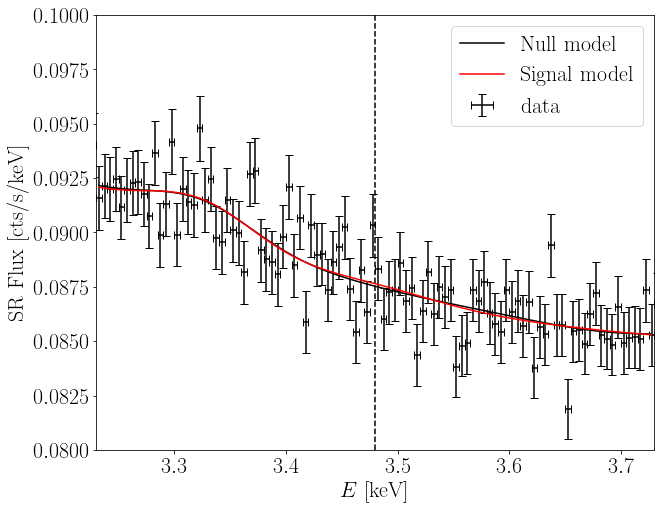

In [9]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(Energies,data,yerr=data_yerrs,xerr=(Energies[1]-Energies[0])/2.,
             color="black",label="data",marker="o", fmt='none',capsize=4)
plt.plot(Energies_reduced,mod_poly_two_lines(Energies_reduced,mn_null_line.x),'k-',label =r"Null model")
plt.plot(Energies_reduced,mod_poly_two_lines(Energies_reduced,mn_line.x[1:])+mn_line.x[0]*mod_UXL_reduced,
         'r-',label =r"Signal model")
plt.axvline(EUXL,color="black",linestyle="dashed")
plt.xlim(EUXL-0.25,EUXL+0.25)
plt.ylim(0.08,0.1)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"SR Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

Finally let's compute the associated limit via profile likelihood.

In [10]:
A_sig_array = np.linspace(mn_line.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn_line.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead',
                          options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]

print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(EUXL,limit_signal_strength,D_signal)

The 95% upper limit on the signal flux is 0.02664201119758925 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 2.382479159553265e-11


## Power law background model

Now let's try a power law for the continuum background model (along with the two lines) as done in BMRS. Given that the stacked data is the sum of power laws, we would not expect the stacked data to be a power law itself, although in our relatively clean dataset we find it to be a reasonable description.  

In [11]:
def mod_power_two_lines(ens,x):
    "An extended background model to include two additional lines"
    A, n, S1, S2 = x

    return A*ens**n +  S1*mod_3p3[whs_reduced] + S2*mod_3p7[whs_reduced]

chi2_instance = chi2(Energies_reduced,data_reduced,data_yerrs_reduced,mod_power_two_lines,mod_UXL_reduced)

mn_null_line = minimize(chi2_instance.chi2_null,np.array([0.18244131, -0.58714693,  0.02237754,  0.01157593]),method='Nelder-Mead')

mn_line = minimize(chi2_instance.chi2,np.array([1.e-2,mn_null_line.x[0],mn_null_line.x[1],mn_null_line.x[2],mn_null_line.x[3]]),method='Nelder-Mead',options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})


print "The Delta chi^2 between signal and null model is:", mn_null_line.fun - mn_line.fun
print "The chi^2/DOF of the null-model fit is:", mn_null_line.fun/(len(whs_reduced)-4.)

The Delta chi^2 between signal and null model is: 0.00043135939542082724
The chi^2/DOF of the null-model fit is: 0.9426290489941959


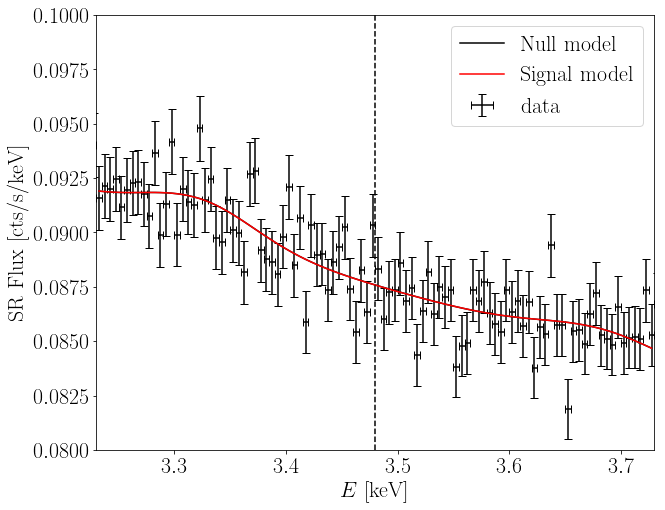

In [12]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(Energies,data,yerr=data_yerrs,xerr=(Energies[1]-Energies[0])/2.,
             color="black",label="data",marker="o", fmt='none',capsize=4)
plt.plot(Energies_reduced,mod_power_two_lines(Energies_reduced,mn_null_line.x),'k-',label =r"Null model")
plt.plot(Energies_reduced,mod_power_two_lines(Energies_reduced,mn_line.x[1:])+mn_line.x[0]*mod_UXL_reduced,
         'r-',label =r"Signal model")
plt.axvline(EUXL,color="black",linestyle="dashed")
plt.xlim(EUXL-0.25,EUXL+0.25)
plt.ylim(0.08,0.1)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"SR Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

In [13]:
A_sig_array = np.linspace(mn_line.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn_line.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead',
                          options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]
print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(EUXL,limit_signal_strength,D_signal)

The 95% upper limit on the signal flux is 0.020575238409308062 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 1.8399540616307525e-11


The power law continuum background does not substantively change the results: we still find no evidence for a line. Note this is the same procedure as in BMRS's test color-coded red in their Fig. 1 and Tab. 1. In that analysis, they find marginal 1.3$\sigma$ evidence for a line, although on our cleaner dataset we found no evidence. 

**NB:** As an aside, BMRS also perform an analysis, color-coded green in their Fig. 1 and Tab. 1, in which they fix the 3.3 keV and 3.7 keV emission lines to their best fit fluxes in the fit. They claim that DRS20, in our Supplementary Material Sec 2.7, also fixed the fluxes of these lines. This statement is incorrect.

# Departing from the narrow window

We now fit the same dataset over the 3-4 keV range. 

Our procedure is as follows. Firstly, we update the dataset. Then we will define a new background model incorporating these additional lines. Finally we repeat our default $\chi^2$ fit procedure. Note that we continue to use a power law continuum background model here. As such, the following analysis is a repetition of the BMRS magenta color-coded analysis on this reduced and low-background dataset. In that magenta analysis, they claim a 4.0$\sigma$ detection of a line at 3.48 keV. Let us see what we obtain on when we include only the observations passing our quality cuts.

In [14]:
whs_reduced = np.where((Energies >= 3.0) & (Energies <= 4.0))[0]
Energies_reduced = Energies[whs_reduced]
data_reduced = data[whs_reduced]
data_yerrs_reduced = data_yerrs[whs_reduced]
data_bkg_reduced = data_bkg[whs_reduced]
data_yerrs_bkg_reduced = data_yerrs_bkg[whs_reduced]
mod_UXL_reduced = mod_UXL[whs_reduced]

arg_3p1 = np.argmin((Es_line-3.12)**2) 
mod_3p1 = mods[arg_3p1]

arg_3p9 = np.argmin((Es_line-3.90)**2)
mod_3p9 = mods[arg_3p9]

arg_3p7 = np.argmin((Es_line-3.68)**2)
mod_3p7 = mods[arg_3p7]

arg_3p3 = np.argmin((Es_line-3.32)**2) 
mod_3p3 = mods[arg_3p3]


def mod_power_four_lines(ens,x):
    A, n,S1, S2, S3, S4 = x
    return A*ens**n + S1*mod_3p3[whs_reduced] + S2*mod_3p7[whs_reduced]+ S3*mod_3p1[whs_reduced] + S4*mod_3p9[whs_reduced]

chi2_instance = chi2(Energies_reduced,data_reduced,data_yerrs_reduced,mod_power_four_lines,mod_UXL_reduced)


x0 = np.array([0.18088868 ,-0.58201284 , 0.02472505 , 0.01364361 , 0.08959867,
  0.03220519])
bounds = np.array([[1e-6,5],[-3,0],[0,0.5],[0,0.5],[0,0.5],[0,0.5]])
mn_null = dual_annealing(chi2_instance.chi2_null,x0=x0,bounds=bounds,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=500)

boundss = np.array([[-0.5,0.5],[1e-6,5],[-3,0],[0,0.1],[0,0.1],[0,0.1],[0,0.2]])
x0s=np.array([1.e-2,mn_null.x[0],mn_null.x[1],mn_null.x[2],mn_null.x[3],mn_null.x[4],mn_null.x[5]])
mn = dual_annealing(chi2_instance.chi2,x0=x0s,bounds=boundss,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=500)

print "Best fit background parameters:", mn_null.x
print "Best fit signal+background parameters:", mn.x

print "The Delta chi^2 between signal and null model is:", mn_null.fun - mn.fun
print "The chi^2/DOF of the null-model fit is:", mn_null.fun/(len(whs_reduced)-6.)

print "NB: the best-fit signal strength in this case is", mn.x[0], "cts/cm$^2$/s/sr"

Best fit background parameters: [ 0.1807753  -0.58187775  0.02547398  0.01436228  0.09052193  0.03304785]
Best fit signal+background parameters: [ 0.0015216   0.18110231 -0.58372105  0.02608541  0.0154532   0.0911047
  0.03434406]
The Delta chi^2 between signal and null model is: 0.03379302143113705
The chi^2/DOF of the null-model fit is: 0.9791145496670692
NB: the best-fit signal strength in this case is 0.0015216044839330481 cts/cm$^2$/s/sr


We find no evidence for a 3.5 keV line when we expand the energy window. Although the best-fit signal strength is positive, the $\Delta \chi^2 \sim 0.03$, which is entirely negligable significance. 

Let's have a look at the best fit signal and background models in this case. There are subtle difference between the two, but no excess is appearing at 3.48 keV.

Additionally, we are defining a fixed signal to plot overtop the data for illustration. The default signal parameters here corresponds to a 2$\sigma$ downward fluctuationn in the signal reported in [Cappelluti et. al. ApJ 2018](https://iopscience.iop.org/article/10.3847/1538-4357/aaaa68/meta) from observations of the Chandra Deep Fields. Note that even taking the conservative downward flucutation, it is not a good fit to the data. This plot appears in our response to BMRS.

In [15]:
flux_ill = 4.8e-11 / return_sin_theta_lim(EUXL,1.,D_signal)
print "Flux [cts/cm^2/s/sr] and sin^(2theta) for illustration: ", flux_ill, return_sin_theta_lim(EUXL,flux_ill,D_signal)

chi2_instance.fix_signal_strength(flux_ill)

mn_f = dual_annealing(chi2_instance.chi2_fixed_signal,x0=x0,bounds=bounds,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=500)
print "Delta chi^2 between fixed signal and null:", mn_null.fun-mn_f.fun

Flux [cts/cm^2/s/sr] and sin^(2theta) for illustration:  0.0536758750798 4.8e-11
Delta chi^2 between fixed signal and null: -40.04152650916589


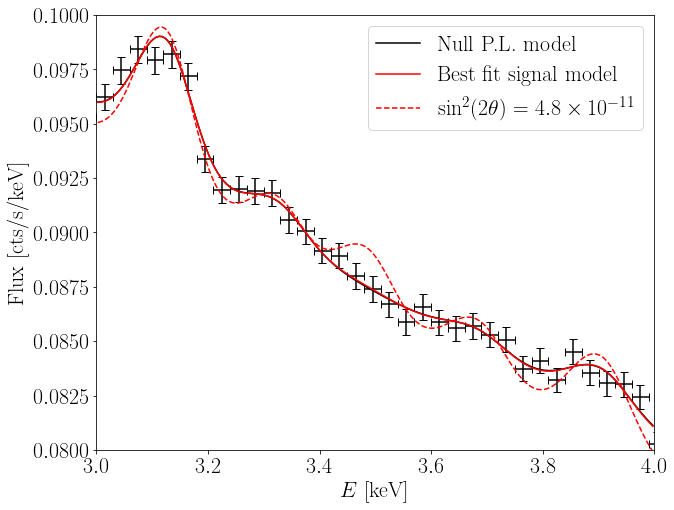

In [16]:
def avg_data(data,n):
    return np.mean(data.reshape(-1, n), axis=1)

fig = plt.figure(figsize=(10,8))

plt.errorbar(avg_data(Energies,6),avg_data(data,6),yerr=np.sqrt(6*avg_data(data_yerrs**2,6))/6.,xerr=6*(Energies[1]-Energies[0])/2.,
             color="black",marker="o", fmt='none',capsize=4) 

plt.plot(Energies_reduced,mod_power_four_lines(Energies_reduced,mn_null.x),
         'k-',label =r"Null P.L. model")
plt.plot(Energies_reduced,mod_power_four_lines(Energies_reduced,mn.x[1:])+mn.x[0]*mod_UXL_reduced,
         'r-',label =r"Best fit signal model")
plt.plot(Energies_reduced,mod_power_four_lines(Energies_reduced,mn_f.x)+chi2_instance._A_sig*mod_UXL_reduced,
         'r--',label =r"$\sin^2(2\theta) = 4.8 \times 10^{-11}$")

plt.xlim(3,4)
plt.ylim(0.08,0.1)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

**NB:** In the plot above we averaged the data solely for presentation purposes, no averaging was performed in the analysis.

Finally, we compute the limit in this case using the by now familiar procedure.

In [17]:
A_sig_array = np.linspace(mn.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead')
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]
print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(EUXL,limit_signal_strength,D_signal)

The 95% upper limit on the signal flux is 0.015232665842012591 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 1.362191038952712e-11


## Now with a polynomial background

Here we repeat the earlier analysis but with a polynomial background model, as used in the stacked analysis in DRS20 Supplementary Material Sec. 2.9.

In [18]:
whs_reduced = np.where((Energies >= 3.0) & (Energies <= 4.0))[0]
Energies_reduced = Energies[whs_reduced]
data_reduced = data[whs_reduced]
data_yerrs_reduced = data_yerrs[whs_reduced]
data_bkg_reduced = data_bkg[whs_reduced]
data_yerrs_bkg_reduced = data_yerrs_bkg[whs_reduced]
mod_UXL_reduced = mod_UXL[whs_reduced]

arg_3p1 = np.argmin((Es_line-3.12)**2) #3.12 #should really be 3.128
mod_3p1 = mods[arg_3p1]

arg_3p9 = np.argmin((Es_line-3.90)**2)
mod_3p9 = mods[arg_3p9]

arg_3p7 = np.argmin((Es_line-3.68)**2)
mod_3p7 = mods[arg_3p7]

arg_3p3 = np.argmin((Es_line-3.32)**2) 
mod_3p3 = mods[arg_3p3]

def mod_poly_four_lines(ens,x):
    A, B, C,S1, S2, S3, S4 = x
    return A+B*ens + C*ens**2 + S1*mod_3p3[whs_reduced] + S2*mod_3p7[whs_reduced]+ S3*mod_3p1[whs_reduced] + S4*mod_3p9[whs_reduced]

chi2_instance = chi2(Energies_reduced,data_reduced,data_yerrs_reduced,mod_poly_four_lines,mod_UXL_reduced)


x0 = np.array([ 0.2015824 , -0.05098609 , 0.0052141 ,  0.02854594 , 0.01742288,
  0.08976637 , 0.029351 ])
bounds = np.array([[-1,1],[-0.5,0.5],[-0.1,0.1],[0,0.2],[0,0.2],[0,0.2],[0,0.2]])
mn_null = dual_annealing(chi2_instance.chi2_null,x0=x0,bounds=bounds,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=3000)

boundss = np.array([[-0.5,0.5],[-1,1],[-0.5,0.5],[-0.1,0.1],[0,0.2],[0,0.2],[0,0.2],[0,0.2]])
x0s=np.array([1.e-2,mn_null.x[0],mn_null.x[1],mn_null.x[2],mn_null.x[3],mn_null.x[4],mn_null.x[5],mn_null.x[6]])
mn = dual_annealing(chi2_instance.chi2,x0=x0s,bounds=boundss,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=3000)

print "Best fit background parameters:", mn_null.x
print "Best fit signal+background parameters:", mn.x

print "The Delta chi^2 between signal and null model is:", mn_null.fun - mn.fun
print "The chi^2/DOF of the null-model fit is:", mn_null.fun/(len(whs_reduced)-7.)

print "NB: the best-fit signal strength in this case is:", mn.x[0], "cts/cm$^2$/s/sr"

Best fit background parameters: [ 0.20091551 -0.05052423  0.00514508  0.02652786  0.01548994  0.08761685
  0.02739853]
Best fit signal+background parameters: [ 0.00607216  0.2010101  -0.05069341  0.00517223  0.02940035  0.01881783
  0.09116903  0.03089509]
The Delta chi^2 between signal and null model is: 0.5487446049041864
The chi^2/DOF of the null-model fit is: 0.980518891711762
NB: the best-fit signal strength in this case is: 0.00607216339159919 cts/cm$^2$/s/sr


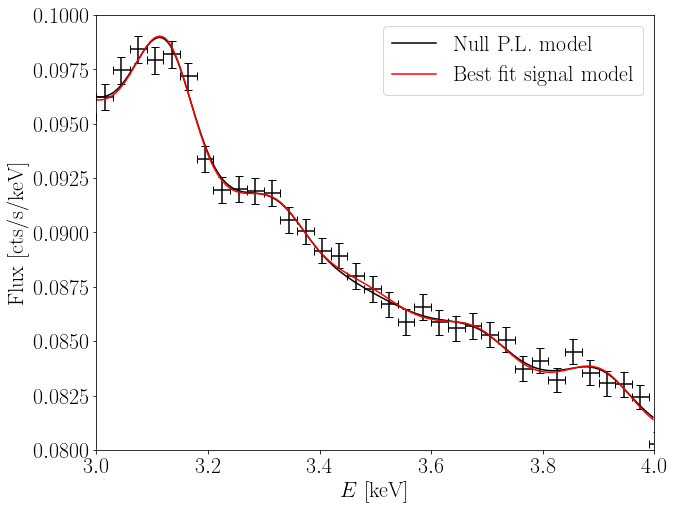

In [19]:
fig = plt.figure(figsize=(10,8))

plt.errorbar(avg_data(Energies,6),avg_data(data,6),yerr=np.sqrt(6*avg_data(data_yerrs**2,6))/6.,xerr=6*(Energies[1]-Energies[0])/2.,
             color="black",marker="o", fmt='none',capsize=4) 

plt.plot(Energies_reduced,mod_poly_four_lines(Energies_reduced,mn_null.x),
         'k-',label =r"Null P.L. model")
plt.plot(Energies_reduced,mod_poly_four_lines(Energies_reduced,mn.x[1:])+mn.x[0]*mod_UXL_reduced,
         'r-',label =r"Best fit signal model")

plt.xlim(3,4)
plt.ylim(0.08,0.1)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

In [20]:
A_sig_array = np.linspace(mn.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead',
                          options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]
print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(EUXL,limit_signal_strength,D_signal)

The 95% upper limit on the signal flux is 0.02781422393515111 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 2.487305045147695e-11


This change to the background continuum model does not change any conclusions. The 3.5 keV line is in tension with these limits.

## Subtract the background data

Now, we subtract off the data taken far away from the Galactic Center.  We use a folded powerlaw for the background continuum under the assumption that the residual flux in the signal region should be astrophysical.

In [21]:
# A folded powerlaw function
def folded_PL(A,n):
    mod_F = np.matmul(det_res,A*Energies**n) 
    return mod_F

def mod_folded_power_four_lines(ens,x):
    A, n,S1, S2, S3, S4 = x
    return folded_PL(A,n)[whs_reduced] + S1*mod_3p3[whs_reduced] + S2*mod_3p7[whs_reduced]+ S3*mod_3p1[whs_reduced] + S4*mod_3p9[whs_reduced]


chi2_instance = chi2(Energies_reduced,data_reduced- data_bkg[whs_reduced],np.sqrt(data_yerrs_reduced**2+data_yerrs_bkg_reduced**2),mod_folded_power_four_lines,mod_UXL_reduced)


x0 = np.array([1.80533176e-02, -5.18514882e-01, 9.80776897e-03, 1.45353856e-04, 6.39560515e-02, 1.84053386e-02])
bounds = np.array([[0.0,0.1],[-2,0],[0,0.1],[0,0.2],[0,0.2],[0,0.2]])
mn_null = dual_annealing(chi2_instance.chi2_null,x0=x0,bounds=bounds,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=1000)

boundss = np.array([[-0.5,0.5],[0.0,0.1],[-2,0],[0,0.1],[0,0.2],[0,0.2],[0,0.2]])
x0s=np.array([1.e-2,mn_null.x[0],mn_null.x[1],mn_null.x[2],mn_null.x[3],mn_null.x[4],mn_null.x[5]])
mn = dual_annealing(chi2_instance.chi2,x0=x0s,bounds=boundss,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=1000)

print "Best fit background parameters:", mn_null.x
print "Best fit signal+background parameters:", mn.x

print "The Delta chi^2 between signal and null model is:", mn_null.fun - mn.fun
print "The chi^2/DOF of the null-model fit is:", mn_null.fun/(len(whs_reduced)-6.)

print "NB: the best-fit signal strength in this case is:", mn.x[0], "cts/cm$^2$/s/sr"

Best fit background parameters: [ 1.80533176e-02 -5.18652456e-01  9.90575404e-03  1.02427156e-04
  6.39560515e-02  1.86563894e-02]
Best fit signal+background parameters: [ 1.44916562e-03  1.60687313e-02 -4.29522829e-01  1.13028621e-02
  3.83633951e-05  6.65749498e-02  1.75828890e-02]
The Delta chi^2 between signal and null model is: 0.10125021484452645
The chi^2/DOF of the null-model fit is: 1.0259200982344832
NB: the best-fit signal strength in this case is: 0.0014491656186800237 cts/cm$^2$/s/sr


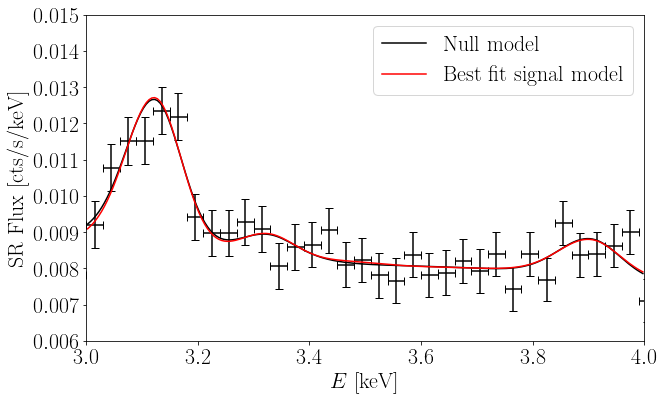

In [22]:
fig = plt.figure(figsize=(10,6))

plt.errorbar(avg_data(Energies,6),avg_data(data-data_bkg,6),yerr=np.sqrt(6*avg_data(data_yerrs**2+data_yerrs_bkg**2,6))/6.,xerr=6*(Energies[1]-Energies[0])/2.,
             color="black",marker="o", fmt='none',capsize=4) #label="data"

plt.plot(Energies_reduced,mod_folded_power_four_lines(Energies_reduced,mn_null.x),
         'k-',label =r"Null model")
plt.plot(Energies_reduced,mod_folded_power_four_lines(Energies_reduced,mn.x[1:])+mn.x[0]*mod_UXL_reduced,
         'r-',label =r"Best fit signal model")

plt.xlim(3,4)
plt.ylim(0.006,0.015)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"SR Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

In [23]:
A_sig_array = np.linspace(mn.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead')
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]

print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(EUXL,limit_signal_strength,D_signal-D_bkg)

The 95% upper limit on the signal flux is 0.01567112720512729 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 2.476370769990894e-11


In this version of the analysis, too, we see no evidence for a 3.5 keV line and obtain comparable limits as in the stacked analyses in the previous sections.

# Include the Quiescent Particle Background (QPB)

Now we will do a joint likelihood including the QPB data.  The QPB data is complicated because the data is correlated from observation to observation.  Thus, summing the data leads to correlated uncertainties. To account for this, we will estimate the uncertainties on the QPB data in a data-driven way by fixing the normalization of the $\chi^2$ function such that the powerlaw gives the expected $\chi^2/{\rm DOF}$.  We note that this is just an approximation, which is not necessary within the context of the full joint likelihood framework.

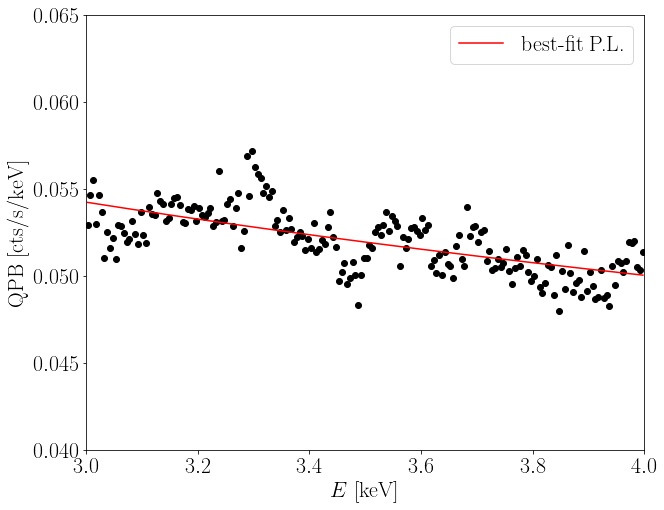

In [24]:
# We are going to fix a powerlaw to the QPB data and then renormalize the chi^2 function
def PL(A,n,ens):
    return A*ens**n

def chi2_QPB_UN(x):
    A,n = x
    mod = PL(A,n,Energies_reduced)
    return np.sum((mod-QPB[whs_reduced])**2)

mn_QPB = minimize(chi2_QPB_UN,[0.084,-0.20],method="Nelder-Mead")
bf_QPB=mn_QPB.x

chi2_not_reduced = chi2_QPB_UN(bf_QPB)

# The function below has the expected normalization
chi2_QPB = lambda x: chi2_QPB_UN(x)/chi2_not_reduced*((len(QPB[whs_reduced])-2.))


fig = plt.figure(figsize=(10,8))
plt.scatter(Energies_reduced,QPB[whs_reduced],marker="o",color="black")
plt.plot(Energies_reduced,PL(bf_QPB[0],bf_QPB[1],Energies_reduced),'r-',label="best-fit P.L.")

plt.xlim(3,4)
plt.ylim(0.04,0.065)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"QPB [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()

In [25]:
def mod_2power_four_lines(ens,x):
    AQPB, nQPB,A, n,S1, S2, S3, S4 = x
    return PL(AQPB,nQPB,ens)+ folded_PL(A,n)[whs_reduced] + S1*mod_3p3[whs_reduced] + S2*mod_3p7[whs_reduced]+ S3*mod_3p1[whs_reduced] + S4*mod_3p9[whs_reduced]

chi2_instance = chi2(Energies_reduced,data_reduced,data_yerrs_reduced,mod_2power_four_lines,mod_UXL_reduced)


x0 = np.array([0.07377512 ,-0.28001362 , 0.15844243, -1.07912658 , 0.02877547,
  0.01134023 , 0.08755627 , 0.03134949])
bounds = np.array([[0.75*bf_QPB[0],1.25*bf_QPB[0]],[-1,0],[0.0001,2.0],[-3,0],[0,0.1],[0,0.1],[0,0.1],[0,0.1]])

# Below is the joint likelihood for the null model
def joint_chi2(x):
    return chi2_QPB(x[:2])+chi2_instance.chi2_null(x)

mn_null = dual_annealing(joint_chi2,x0=x0,bounds=bounds,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=1000)

# Below is the joint likelihood for the signal model
def joint_chi2_sig(x):
    return chi2_QPB(x[1:3])+chi2_instance.chi2(x)
boundss = np.array([[-0.5,0.5],[0.5*bf_QPB[0],2*bf_QPB[0]],[-1,0],[0.0001,2.0],[-3,0],[0,0.1],[0,0.1],[0,0.1],[0,0.1]])
x0s=np.array([1.e-2,mn_null.x[0],mn_null.x[1],mn_null.x[2],mn_null.x[3],mn_null.x[4],mn_null.x[5],mn_null.x[6],mn_null.x[7]])
mn = dual_annealing(joint_chi2_sig,x0=x0s,bounds=boundss,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=1000)

print "The Delta chi^2 between signal and null model is:", mn_null.fun - mn.fun
print "NB: the best-fit signal strength in this case is:", mn.x[0], "cts/cm$^2$/s/sr"

The Delta chi^2 between signal and null model is: 0.45016371056283333
NB: the best-fit signal strength in this case is: 0.005545658335402866 cts/cm$^2$/s/sr


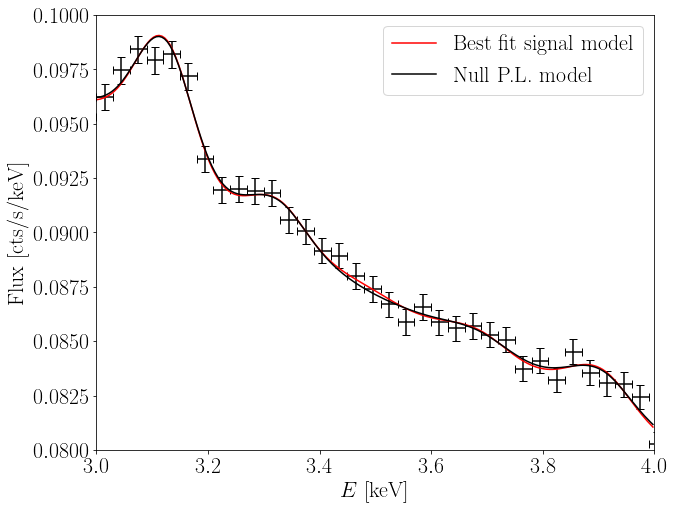

In [26]:
fig = plt.figure(figsize=(10,8))

plt.errorbar(avg_data(Energies,6),avg_data(data,6),yerr=np.sqrt(6*avg_data(data_yerrs**2,6))/6.,xerr=6*(Energies[1]-Energies[0])/2.,
             color="black",marker="o", fmt='none',capsize=4) #label="data"

plt.plot(Energies_reduced,mod_2power_four_lines(Energies_reduced,mn.x[1:])+mn.x[0]*mod_UXL_reduced,
         'r-',label =r"Best fit signal model")
x0 = np.array([bf_QPB[0],bf_QPB[1], 0.064218, -0.4306988 , 0.02542355 , 0.01451921 , 0.09027154,  0.03331636])
plt.plot(Energies_reduced,mod_2power_four_lines(Energies_reduced,mn_null.x),
         'k-',label =r"Null P.L. model")

plt.xlim(3,4)

plt.ylim(0.08,0.1)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

In [27]:
A_sig_array = np.linspace(mn.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead')
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]

print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(EUXL,limit_signal_strength,D_signal)

The 95% upper limit on the signal flux is 0.019016670961038363 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 1.700578155032655e-11


Finally, including the QPB in our analysis does not significantly change the results.

# Summary

To summarize, we see no evidence of a 3.5 keV line in any of our analysis variations here. We obtain the following limits on $\sin^2(2\theta)$ for $E_{\rm UXL} = 3.48$ keV:

* Quadratic background fit within $E_{\rm UXL} \pm 0.25$ keV: $2.35 \times 10^{-11}$

* Power law background fit within $E_{\rm UXL} \pm 0.25$ keV: $1.82 \times 10^{-11}$

* Power law background fit from 3 to 4 keV: $1.34 \times 10^{-11}$

* Quadratic background fit from 3 to 4 keV: $2.45 \times 10^{-11}$

* Power law background fit on background-subtracted data from 3 to 4 keV: $1.87 \times 10^{-11}$

* Power law background fit with joint (X-ray + QPB) likelihood from 3 to 4 keV: $1.68 \times 10^{-11}$

Although these limits are much weaker than our fiducial limit presented in DRS20, they still strongly constrain the 3.5 keV line.